## Loading Trained Models and Data

In [2]:
import numpy as np
import torch
from torch.utils.data import DataLoader
from torch.utils.data import Subset
from torchvision.transforms import ToTensor
from torchvision.datasets import MNIST
from torch.nn import functional as F
import imutils
import cv2

In [3]:
# Loading data from MNIST and grabbing N data points
N = 10
test_data = MNIST(root='data', train=False, download=True, transform=ToTensor())
indxs = np.random.choice(range(len(test_data)), size=(N,))
test_data = Subset(test_data, indxs)

# Initializing test data loader
test_data_loader = DataLoader(test_data, batch_size=1)

In [4]:
# Loading our saved models
# the following abbreviations are used throughout:
# freq -> normal LeNet
# bayes -> bayesian version of LeNet

freq_path = 'output/freq_model.pth'
bayes_path = 'output/bayesian_model.pth'

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

freq_model = torch.load(freq_path).to(device)
bayes_model = torch.load(bayes_path).to(device)

freq_model.eval()
bayes_model.eval()

;

''

## Making Predictions

In [5]:
pictures = []

In [8]:
# let's make a batch of predictions for the frequentist model
# after we write this explicitly, there should be some parts we 
# can make into their own functions

torch.no_grad()

trial_no = 0

for (img, label) in test_data_loader:
    trial_no += 1

    # getting original img and interpreting the label
    original_img = img.numpy().squeeze(axis=(0,1))
    ground_truth_label = test_data.dataset.classes[label.numpy()[0]]

    #pictures.append(original_img)
    
    network_output = freq_model(img)
    prediction = torch.mean(network_output, dim=0).cpu().detach().numpy()
    predicted_indx = prediction.argmax(axis=0)
    predicted_label = test_data.dataset.classes[predicted_indx]
    
    color = (0, 255, 0) if ground_truth_label == predicted_label else (0, 0, 255)
    original_img = np.dstack([original_img] * 3)
    original_img = imutils.resize(original_img, width=128)
    original_img = cv2.putText(original_img, ground_truth_label, (2, 25), cv2.FONT_HERSHEY_SIMPLEX, 0.75, color, 2)
    #text_summary = "Trial: {}\n Ground truth label: {}, predicted label: {}\n".format(trial_no, ground_truth_label, predicted_label)
    
    cv2.imwrite('test_output.png', original_img*255)
    #display(Image(filename='test_output.png'))
    
    
    
    


In [9]:
# function: get pred for single model/image
# function: make prediction grid(n)
# function: get pred and uncertainties for a single model/image
# function: get p_hat from network out
# function: display pred's and uc's 

In [10]:
from IPython.display import Image, display


original_img = pictures[0]
original_img = np.dstack([original_img] * 3)
original_img = imutils.resize(original_img, width=128)

cv2.imwrite('test_output.png', original_img*255)

#display(Image(filename='test_output.png'))

IndexError: list index out of range

Trial: 31
 Ground truth label: 9 - nine, predicted label: 9 - nine
 uncertainty from model: 0.0
uncertainty from data: 0.0
total uncertainty: 0.0


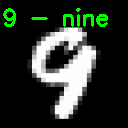

Trial: 32
 Ground truth label: 0 - zero, predicted label: 0 - zero
 uncertainty from model: 0.0
uncertainty from data: 0.0
total uncertainty: 0.0


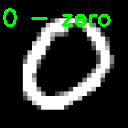

Trial: 33
 Ground truth label: 3 - three, predicted label: 3 - three
 uncertainty from model: 0.0
uncertainty from data: 0.0
total uncertainty: 0.0


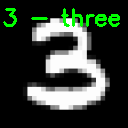

Trial: 34
 Ground truth label: 5 - five, predicted label: 5 - five
 uncertainty from model: 0.0
uncertainty from data: 0.0
total uncertainty: 0.0


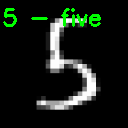

Trial: 35
 Ground truth label: 8 - eight, predicted label: 8 - eight
 uncertainty from model: 0.0
uncertainty from data: 0.0
total uncertainty: 0.0


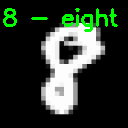

Trial: 36
 Ground truth label: 2 - two, predicted label: 2 - two
 uncertainty from model: 0.0
uncertainty from data: 0.0
total uncertainty: 0.0


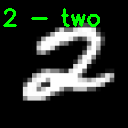

Trial: 37
 Ground truth label: 8 - eight, predicted label: 8 - eight
 uncertainty from model: 0.0
uncertainty from data: 0.0
total uncertainty: 0.0


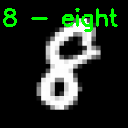

Trial: 38
 Ground truth label: 3 - three, predicted label: 3 - three
 uncertainty from model: 0.0
uncertainty from data: 0.0
total uncertainty: 0.0


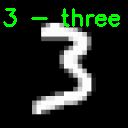

Trial: 39
 Ground truth label: 8 - eight, predicted label: 8 - eight
 uncertainty from model: 3.197442310920451e-14
uncertainty from data: 1.7881393432617188e-07
total uncertainty: 1.7881393432617473e-07


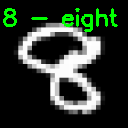

Trial: 40
 Ground truth label: 3 - three, predicted label: 3 - three
 uncertainty from model: 0.0
uncertainty from data: 0.0
total uncertainty: 0.0


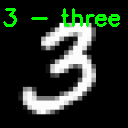

In [49]:
# bayes model + trying to calculate uncertainties

torch.no_grad()

trail_no = 0
T = 15

for (img, label) in test_data_loader:
    trial_no += 1

    # getting original img and interpreting the label
    original_img = img.numpy().squeeze(axis=(0,1))
    ground_truth_label = test_data.dataset.classes[label.numpy()[0]]
    
    input_image = img.unsqueeze(0)
    input_images = img.repeat(T, 1, 1, 1)

    network_output = bayes_model(input_images)
    prediction = torch.mean(network_output, dim=0).cpu().detach().numpy()
    predicted_indx = prediction.argmax(axis=0)
    predicted_label = test_data.dataset.classes[predicted_indx]
    
    
    # getting uncertainties
    normalized = False
    if normalized:
        pred = F.softplus(network_output)
        p_hat = pred / torch.sum(pred, dim=1).unsqueeze(1)
    else:
        p_hat = F.softmax(network_output, dim=1)
    p_hat = p_hat.detach().cpu().numpy()
    p_bar = np.mean(p_hat, axis=0)
    
    temp = p_hat - np.expand_dims(p_bar, 0)
    epistemic_ucs = np.dot(temp.T, temp) / T
    epistemic_ucs = np.diag(epistemic_ucs)

    aleatoric_ucs = np.diag(p_bar) - (np.dot(p_hat.T, p_hat) / T)
    aleatoric_ucs = np.diag(aleatoric_ucs)
    
    epistemic = epistemic_ucs[predicted_indx]
    aleatoric = aleatoric_ucs[predicted_indx]
    total_uncertainty = np.sqrt(epistemic**2 + aleatoric**2)
    
    
    color = (0, 255, 0) if ground_truth_label == predicted_label else (0, 0, 255)
    original_img = np.dstack([original_img] * 3)
    original_img = imutils.resize(original_img, width=128)
    original_img = cv2.putText(original_img, ground_truth_label, (2, 25), cv2.FONT_HERSHEY_SIMPLEX, 0.75, color, 2)
    text_summary = "Trial: {}\n Ground truth label: {}, predicted label: {}\n".format(trial_no, ground_truth_label, predicted_label)
    uncertainty_annotation = "uncertainty from model: {}\nuncertainty from data: {}\ntotal uncertainty: {}".format(epistemic, aleatoric, total_uncertainty)
    
    
    print(text_summary, uncertainty_annotation)
    cv2.imwrite('test_output.png', original_img*255)
    display(Image(filename='test_output.png'))

In [12]:
import sys
!{sys.executable} -m pip install PrettyTable

DEPRECATION: Configuring installation scheme with distutils config files is deprecated and will no longer work in the near future. If you are using a Homebrew or Linuxbrew Python, please see discussion at https://github.com/Homebrew/homebrew-core/issues/76621


In [13]:
from prettytable import PrettyTable

In [47]:
def make_bayes_image(img, label, i=0):
    with torch.no_grad():
        # getting original img and interpreting the label
        original_img = img.numpy().squeeze(axis=(0,1))
        ground_truth_label = test_data.dataset.classes[label.numpy()[0]]

        input_image = img.unsqueeze(0)
        input_images = img.repeat(T, 1, 1, 1)

        network_output = bayes_model(input_images)
        prediction = torch.mean(network_output, dim=0).cpu().detach().numpy()
        predicted_indx = prediction.argmax(axis=0)
        predicted_label = test_data.dataset.classes[predicted_indx]


        # getting uncertainties
        normalized = False
        if normalized:
            pred = F.softplus(network_output)
            p_hat = pred / torch.sum(pred, dim=1).unsqueeze(1)
        else:
            p_hat = F.softmax(network_output, dim=1)
        p_hat = p_hat.detach().cpu().numpy()
        p_bar = np.mean(p_hat, axis=0)

        temp = p_hat - np.expand_dims(p_bar, 0)
        epistemic_ucs = np.dot(temp.T, temp) / T
        epistemic_ucs = np.diag(epistemic_ucs)

        aleatoric_ucs = np.diag(p_bar) - (np.dot(p_hat.T, p_hat) / T)
        aleatoric_ucs = np.diag(aleatoric_ucs)

        epistemic = epistemic_ucs[predicted_indx]
        aleatoric = aleatoric_ucs[predicted_indx]
        total_uncertainty = np.sqrt(epistemic**2 + aleatoric**2)


        color = (0, 255, 0) if ground_truth_label == predicted_label else (0, 0, 255)
        original_img = np.dstack([original_img] * 3)
        original_img = imutils.resize(original_img, width=128)
        original_img = cv2.putText(original_img, ground_truth_label, (2, 25), cv2.FONT_HERSHEY_SIMPLEX, 0.75, color, 2)
        text_summary = "Trial: {}\n Ground truth label: {}, predicted label: {}\n".format(trial_no, ground_truth_label, predicted_label)
        uncertainty_annotation = "uncertainty from model: {}\nuncertainty from data: {}\ntotal uncertainty: {}".format(epistemic, aleatoric, total_uncertainty)


        #print(text_summary, uncertainty_annotation)
        cv2.imwrite('bayes_image_{}.png'.format(i), original_img*255)
        display(Image(filename='bayes_image_{}.png'.format(i)))
        
        uc_table = PrettyTable()
        uc_table.add_column("Category", ['Ground Truth', 'Prediction', 'Epistemic Uncertainty', 'Aleatoric Uncertainty', 'Total Uncertainty'])
        uc_table.add_column("Result", [ground_truth_label, predicted_label, epistemic, aleatoric, total_uncertainty])
        print(uc_table.get_string())

            
            

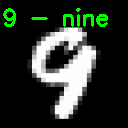

+-----------------------+-----------------------+
|        Category       |         Result        |
+-----------------------+-----------------------+
|      Ground Truth     |        9 - nine       |
|       Prediction      |        9 - nine       |
| Epistemic Uncertainty |      5.684342e-14     |
| Aleatoric Uncertainty |     7.1525574e-07     |
|   Total Uncertainty   | 7.152557373046897e-07 |
+-----------------------+-----------------------+


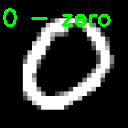

+-----------------------+----------+
|        Category       |  Result  |
+-----------------------+----------+
|      Ground Truth     | 0 - zero |
|       Prediction      | 0 - zero |
| Epistemic Uncertainty |   0.0    |
| Aleatoric Uncertainty |   0.0    |
|   Total Uncertainty   |   0.0    |
+-----------------------+----------+


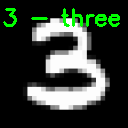

+-----------------------+-----------+
|        Category       |   Result  |
+-----------------------+-----------+
|      Ground Truth     | 3 - three |
|       Prediction      | 3 - three |
| Epistemic Uncertainty |    0.0    |
| Aleatoric Uncertainty |    0.0    |
|   Total Uncertainty   |    0.0    |
+-----------------------+-----------+


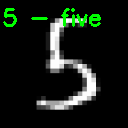

+-----------------------+----------+
|        Category       |  Result  |
+-----------------------+----------+
|      Ground Truth     | 5 - five |
|       Prediction      | 5 - five |
| Epistemic Uncertainty |   0.0    |
| Aleatoric Uncertainty |   0.0    |
|   Total Uncertainty   |   0.0    |
+-----------------------+----------+


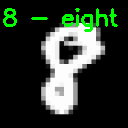

+-----------------------+-----------+
|        Category       |   Result  |
+-----------------------+-----------+
|      Ground Truth     | 8 - eight |
|       Prediction      | 8 - eight |
| Epistemic Uncertainty |    0.0    |
| Aleatoric Uncertainty |    0.0    |
|   Total Uncertainty   |    0.0    |
+-----------------------+-----------+


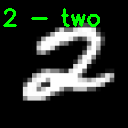

+-----------------------+---------+
|        Category       |  Result |
+-----------------------+---------+
|      Ground Truth     | 2 - two |
|       Prediction      | 2 - two |
| Epistemic Uncertainty |   0.0   |
| Aleatoric Uncertainty |   0.0   |
|   Total Uncertainty   |   0.0   |
+-----------------------+---------+


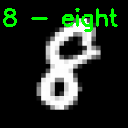

+-----------------------+-----------+
|        Category       |   Result  |
+-----------------------+-----------+
|      Ground Truth     | 8 - eight |
|       Prediction      | 8 - eight |
| Epistemic Uncertainty |    0.0    |
| Aleatoric Uncertainty |    0.0    |
|   Total Uncertainty   |    0.0    |
+-----------------------+-----------+


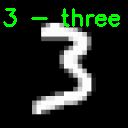

+-----------------------+-----------+
|        Category       |   Result  |
+-----------------------+-----------+
|      Ground Truth     | 3 - three |
|       Prediction      | 3 - three |
| Epistemic Uncertainty |    0.0    |
| Aleatoric Uncertainty |    0.0    |
|   Total Uncertainty   |    0.0    |
+-----------------------+-----------+


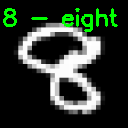

+-----------------------+-----------+
|        Category       |   Result  |
+-----------------------+-----------+
|      Ground Truth     | 8 - eight |
|       Prediction      | 8 - eight |
| Epistemic Uncertainty |    0.0    |
| Aleatoric Uncertainty |    0.0    |
|   Total Uncertainty   |    0.0    |
+-----------------------+-----------+


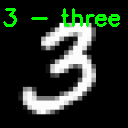

+-----------------------+-----------+
|        Category       |   Result  |
+-----------------------+-----------+
|      Ground Truth     | 3 - three |
|       Prediction      | 3 - three |
| Epistemic Uncertainty |    0.0    |
| Aleatoric Uncertainty |    0.0    |
|   Total Uncertainty   |    0.0    |
+-----------------------+-----------+


In [48]:
i = 0
for (img, label) in test_data_loader:
    i += 1
    make_bayes_image(img, label, i=i)

In [46]:
def get_prediction(model, img, label, T=15):
    
    with torch.no_grad():

        # getting original img and interpreting the label
        original_img = img.numpy().squeeze(axis=(0,1))
        ground_truth_label = test_data.dataset.classes[label.numpy()[0]]

        input_image = img.unsqueeze(0)
        input_images = img.repeat(T, 1, 1, 1)
        
        # getting network output
        network_output = model(input_images)
        prediction = torch.mean(network_output, dim=0).cpu().detach().numpy()
        predicted_indx = prediction.argmax(axis=0)
        predicted_label = test_data.dataset.classes[predicted_indx]
        
    results = {
        'ground_truth_label': ground_truth_label,
        'predicted_label': predicted_label
    }

    return results

In [20]:
results = []
for (img, label) in test_data_loader:
    results.append(get_prediction(bayes_model, img, label))

In [23]:
results[:3]

[{'ground_truth_label': '9 - nine', 'predicted_label': '9 - nine'},
 {'ground_truth_label': '0 - zero', 'predicted_label': '0 - zero'},
 {'ground_truth_label': '3 - three', 'predicted_label': '3 - three'}]

In [24]:
def make_prediction_image(img, prediction_results, save_file='test_output.png'):
    ground_truth_label = prediction_results['ground_truth_label']
    predicted_label = prediction_results['predicted_label']
    color = (0, 255, 0) if ground_truth_label == predicted_label else (0, 0, 255)
    
    original_img = img.numpy().squeeze(axis=(0,1))
    original_img = np.dstack([original_img] * 3)
    original_img = imutils.resize(original_img, width=128)
    original_img = cv2.putText(original_img, ground_truth_label, (2, 25), cv2.FONT_HERSHEY_SIMPLEX, 0.75, color, 2)
    
    #text_summary = "Trial: {}\n Ground truth label: {}, predicted label: {}\n".format(trial_no, ground_truth_label, predicted_label)
    #uncertainty_annotation = "uncertainty from model: {}\nuncertainty from data: {}\ntotal uncertainty: {}".format(epistemic, aleatoric, total_uncertainty)
    #print(text_summary, uncertainty_annotation)
    
    cv2.imwrite(save_file, original_img*255)

    return

In [25]:
results[-1]

{'ground_truth_label': '3 - three', 'predicted_label': '3 - three'}

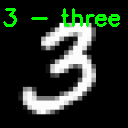

In [26]:
for (img, label) in test_data_loader:
    make_prediction_image(img, get_prediction(bayes_model, img, label))

display(Image(filename='test_output.png'))

In [43]:
def get_prediction_with_uncertainties(model, img, label, T=15, normalized=False):
    with torch.no_grad():
        # getting original img and interpreting the label
        original_img = img.numpy().squeeze(axis=(0,1))
        ground_truth_label = test_data.dataset.classes[label.numpy()[0]]

        input_image = img.unsqueeze(0)
        input_images = img.repeat(T, 1, 1, 1)
        
        # getting network output
        network_output = bayes_model(input_images)
        prediction = torch.mean(network_output, dim=0).cpu().detach().numpy()
        predicted_indx = prediction.argmax(axis=0)
        predicted_label = test_data.dataset.classes[predicted_indx]

        # getting uncertainties
        if normalized:
            pred = F.softplus(network_output)
            p_hat = pred / torch.sum(pred, dim=1).unsqueeze(1)
        else:
            p_hat = F.softmax(network_output, dim=1)
        p_hat = p_hat.detach().cpu().numpy()
        p_bar = np.mean(p_hat, axis=0)

        temp = p_hat - np.expand_dims(p_bar, 0)
        epistemic_ucs = np.dot(temp.T, temp) / T
        epistemic_ucs = np.diag(epistemic_ucs)

        aleatoric_ucs = np.diag(p_bar) - (np.dot(p_hat.T, p_hat) / T)
        aleatoric_ucs = np.diag(aleatoric_ucs)

        epistemic = epistemic_ucs[predicted_indx]
        aleatoric = aleatoric_ucs[predicted_indx]
        total_uncertainty = np.sqrt(epistemic**2 + aleatoric**2)

        results = {
            'ground_truth_label': ground_truth_label,
            'predicted_label': predicted_label,
            'epistemic_uncertainty': epistemic,
            'aleatoric_uncertainty': aleatoric,
            'total_uncertainty': total_uncertainty
        }
        
        return results

            
            

In [54]:
uncertain_results = []
for (img, label) in test_data_loader:
    uncertain_results.append(get_prediction_with_uncertainties(bayes_model, img, label))

In [55]:
uncertain_results[0]['epistemic_uncertainty']

5.684342e-14

In [57]:
def make_uncertainties_ascii(prediction_results, show=True):

    uc_table = PrettyTable()
    uc_table.add_column("Category", ['Ground Truth', 'Prediction', 'Epistemic Uncertainty', 'Aleatoric Uncertainty', 'Total Uncertainty'])
    uc_table.add_column("Result", [ground_truth_label, predicted_label, epistemic, aleatoric, total_uncertainty])
    table_str = uc_table.get_string()
    if show:
        print(table_str)
    
    return table_str




In [58]:
make_uncertainties_ascii(uncertain_results[0])

+-----------------------+-----------+
|        Category       |   Result  |
+-----------------------+-----------+
|      Ground Truth     | 3 - three |
|       Prediction      | 3 - three |
| Epistemic Uncertainty |    0.0    |
| Aleatoric Uncertainty |    0.0    |
|   Total Uncertainty   |    0.0    |
+-----------------------+-----------+


'+-----------------------+-----------+\n|        Category       |   Result  |\n+-----------------------+-----------+\n|      Ground Truth     | 3 - three |\n|       Prediction      | 3 - three |\n| Epistemic Uncertainty |    0.0    |\n| Aleatoric Uncertainty |    0.0    |\n|   Total Uncertainty   |    0.0    |\n+-----------------------+-----------+'